# A/B testing with Amazon SageMaker

A/B testing is similar to canary testing, but it has larger user groups and a longer timescale, typically days or even weeks. For this type of testing, Amazon SageMaker endpoint configuration uses two production variants: one for model A, and one for model B. To begin, configure the settings for both models to balance traffic between them equally (50/50) and make sure that both models have identical instance configurations. After you have monitored the performance of both models with the initial setting of equal weights, you can either gradually change the traffic weights to put the models out of balance (60/40, 80/20, etc.), or you can change the weights in a single step, continuing until a single model is processing all of the live traffic.

For the A/B testing you are doing, the models are using two different algorithms for the same classification problem. We have updated code of the ModelA code with the **decision tree** algorithm and ModelB with the **random forest** algorithm. It is also best practice to use different hyperparameters with the same algorithm to find the optimized iteration.

In this notebook you will:
* Evaluate models by invoking specific variants
* Gradually release a new model by specifying traffic distribution

**Note** Code cells display their status to the left of the code cell.
  - Cell has not run: In [ ]
  - Cell is scheduled to run or is currently running: In [\*]
  - Cell has completed running: In [#], where # is a unique run number

### Prerrequisites

First, ensure you have the updated version of boto3, which includes the latest SageMaker features:

In [1]:
!pip install -U awscli

     |████████████████████████████████| 3.6 MB 7.3 MB/s eta 0:00:01
     |████████████████████████████████| 7.5 MB 61.7 MB/s eta 0:00:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.20.75
    Uninstalling botocore-1.20.75:
      Successfully uninstalled botocore-1.20.75
  Attempting uninstall: awscli
    Found existing installation: awscli 1.19.75
    Uninstalling awscli-1.19.75:
      Successfully uninstalled awscli-1.19.75
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 1.2.1 requires botocore<1.19.53,>=1.19.52, but you have botocore 1.20.78 which is incompatible.


## Step 1: Configuration

Let's set up some required imports and basic initial variables.

In [2]:
%%time
%matplotlib inline
from datetime import datetime, timedelta
import time
import os
import boto3
import re
import json
from sagemaker import get_execution_role, session
from sagemaker.s3 import S3Downloader, S3Uploader

region= boto3.Session().region_name
role = get_execution_role()
sm_session = session.Session(boto3.Session())
sm = boto3.Session().client("sagemaker")
sm_runtime = boto3.Session().client("sagemaker-runtime")

CPU times: user 1.89 s, sys: 415 ms, total: 2.3 s
Wall time: 9.37 s


Determine the name of the S3 modelDataBucket.

In [3]:
bucket = ''
s3 = boto3.resource('s3')
for buckets in s3.buckets.all():
    if 'modeldatabucket' in buckets.name:
        bucket = buckets.name
print(bucket)
prefix = 'v1.0/validation'

qls-173911-bb8bddb154275aaf-modeldatabucket-1oq18du3yfgxy


Enter the **endpoint name** you copied in your notepad earlier in the task.

In [4]:
endpoint_name = 'enter_endpoint_name'
if 'enter_endpoint_name' in endpoint_name:
    raise Exception('You need to update the endpoint_name')

Download data from the S3 bucket.

In [5]:
S3Downloader.download(s3_uri=f"s3://{bucket}/{prefix}/iris.csv", local_path= 'data/')

Read the data in pandas dataframe.

In [6]:
import pandas as pd
import numpy as np

shape=pd.read_csv("data/iris.csv", header=None)
shape.sample(3)

,0,1,2,3,4
40,1,6.1,2.9,4.7,1.4
22,0,4.7,3.2,1.3,0.2
15,2,6.4,2.8,5.6,2.2


Create the sample data for generating traffic.

In [7]:
import itertools

a = [10*i for i in range(3)]
b = [10+i for i in range(10)]
indices = [i+j for i,j in itertools.product(a,b)]

test_data = shape.drop(shape.columns[[0]],axis=1)
test_data = test_data.iloc[indices]
test_data_with_label = shape.iloc[indices]

Update the randomized test data to the local directory.

In [8]:
test_data.to_csv("data/data-test.csv",index=False,header=False)
test_data_with_label.to_csv("data/data-test-label.csv",index=False,header=False)

## Step 2: Invoke the deployed models

You can send data to the endpoint to get inferences in real time.

This step invokes the endpoint with included sample data for about 2 minutes.

In [9]:
# get a subset of test data for a quick test
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")
predictions = ''

with open('data/data-test.csv', 'r') as f:
    for row in f:
        print(".", end="", flush=True)
        payload = row.rstrip('\n')
        response = sm_runtime.invoke_endpoint(EndpointName=endpoint_name,
                                   ContentType="text/csv",
                                   Body=payload)
        predictions = ','.join([predictions, response['Body'].read().decode('utf-8')])
        time.sleep(0.5)

predictions = predictions.replace('\n','')
predictions = predictions.split(",")
predictions.pop(0)
print("="*20)
print(predictions)
print("Done!") 

Sending test traffic to the endpoint Endpoint-63be92ef-5728-43e0-80ed-d6e665750f8b. 
Please wait...
..............................====================
['0', '0', '0', '0', '0', '2', '1', '1', '2', '1', '2', '1', '0', '2', '0', '2', '2', '0', '0', '2', '2', '2', '0', '1', '0', '0', '2', '1', '2', '1']
Done!


In [10]:
labels = test_data_with_label[0].to_numpy()
preds = np.array(predictions)
preds = preds.astype(np.int)

In [11]:
# Calculate accuracy
accuracy = np.count_nonzero(preds == labels) / len(labels)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9333333333333333


### Invocations per variant

Amazon SageMaker emits metrics, such as latency and invocations (full list of metrics [here](https://alpha-docs-aws.amazon.com/sagemaker/latest/dg/monitoring-cloudwatch.html)), for each variant in Amazon CloudWatch. Let’s query CloudWatch to get the number of invocations per variant, which will show how invocations are split across variants.

In [12]:
cw = boto3.Session().client("cloudwatch")

def get_invocation_metrics_for_endpoint_variant(endpoint_name,
                                                variant_name,
                                                start_time,
                                                end_time):
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName="Invocations",
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=["Sum"],
        Dimensions=[
            {
                "Name": "EndpointName",
                "Value": endpoint_name
            },
            {
                "Name": "VariantName",
                "Value": variant_name
            }
        ]
    )
    return pd.DataFrame(metrics["Datapoints"])\
            .sort_values("Timestamp")\
            .set_index("Timestamp")\
            .drop("Unit", axis=1)\
            .rename(columns={"Sum": variant_name})

def plot_endpoint_metrics(start_time=None):
    start_time = start_time or datetime.now() - timedelta(minutes=60)
    end_time = datetime.now()
    metrics_variant1 = get_invocation_metrics_for_endpoint_variant(endpoint_name, "Variant1", start_time, end_time)
    metrics_variant2 = get_invocation_metrics_for_endpoint_variant(endpoint_name, "Variant2", start_time, end_time)
    metrics_variants = metrics_variant1.join(metrics_variant2, how="outer")
    metrics_variants.plot()
    return metrics_variants

Waiting a minute for initial metric creation...


,Variant1,Variant2
Timestamp,,
2021-05-24 16:44:00+00:00,0.0,0.0
2021-05-24 16:45:00+00:00,20.0,20.0
2021-05-24 16:46:00+00:00,0.0,0.0
2021-05-24 16:47:00+00:00,0.0,0.0
2021-05-24 16:48:00+00:00,0.0,0.0
2021-05-24 16:49:00+00:00,0.0,0.0
2021-05-24 16:50:00+00:00,0.0,0.0
2021-05-24 16:51:00+00:00,0.0,0.0
2021-05-24 16:52:00+00:00,0.0,0.0


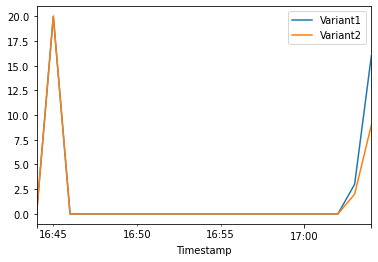

In [13]:
print("Waiting a minute for initial metric creation...")
time.sleep(60)
plot_endpoint_metrics()

**Note:** If you observe failure, such as a blank graph, re-run the previous step.

### Invoke a specific variant

Now, let’s invoke a specific variant. For this, simply use the new parameter to define which specific ProductionVariant you want to invoke. Let's use this to invoke Variant1 for all requests.

### Variant 1

In [14]:
predictions1 = ''

print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")
with open('data/data-test.csv', 'r') as f:
    for row in f:
        print(".", end="", flush=True)
        payload = row.rstrip('\n')
        response = sm_runtime.invoke_endpoint(EndpointName=endpoint_name,
                                   ContentType="text/csv",
                                   Body=payload,
                                   TargetVariant='Variant1')
        predictions1 = ','.join([predictions1, response['Body'].read().decode('utf-8')])
        time.sleep(0.5)

predictions1 = predictions1.replace('\n','')
predictions1 = predictions1.split(",")
predictions1.pop(0)
print("="*20)
print(predictions1)
print("Done!") 

Sending test traffic to the endpoint Endpoint-63be92ef-5728-43e0-80ed-d6e665750f8b. 
Please wait...
..............................====================
['0', '0', '0', '0', '0', '2', '1', '1', '2', '1', '2', '1', '0', '2', '0', '2', '2', '0', '0', '2', '2', '2', '0', '1', '0', '0', '2', '1', '2', '1']
Done!


,Variant1,Variant2
Timestamp,,
2021-05-24 16:44:00+00:00,0.0,0.0
2021-05-24 16:45:00+00:00,20.0,20.0
2021-05-24 16:46:00+00:00,0.0,0.0
2021-05-24 16:47:00+00:00,0.0,0.0
2021-05-24 16:48:00+00:00,0.0,0.0
2021-05-24 16:49:00+00:00,0.0,0.0
2021-05-24 16:50:00+00:00,0.0,0.0
2021-05-24 16:51:00+00:00,0.0,0.0
2021-05-24 16:52:00+00:00,0.0,0.0


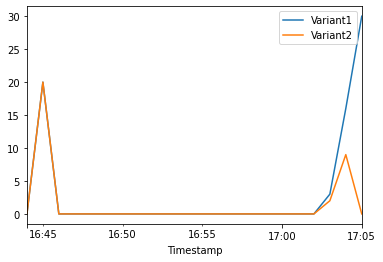

In [15]:
time.sleep(60) #let metrics catch up
plot_endpoint_metrics()

**Note:** If you observe failure, such as a blank graph, re-run the previous step.

### Evaluate performance of variant 1

In [16]:
# Calculate accuracy

labels1 = test_data_with_label[0].to_numpy()
preds1 = np.array(predictions1)
preds1 = preds1.astype(np.int)

accuracy1 = np.count_nonzero(preds1 == labels1) / len(labels1)
print(f"Accuracy_variant1: {accuracy1}")

Accuracy_variant1: 0.9333333333333333


### Variant 2

In [17]:
predictions2 = ''

print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")
with open('data/data-test.csv', 'r') as f:
    for row in f:
        print(".", end="", flush=True)
        payload = row.rstrip('\n')
        response = sm_runtime.invoke_endpoint(EndpointName=endpoint_name,
                                   ContentType="text/csv",
                                   Body=payload,
                                   TargetVariant='Variant2')
        predictions2 = ','.join([predictions2, response['Body'].read().decode('utf-8')])
        time.sleep(0.5)

predictions2 = predictions2.replace('\n','')
predictions2 = predictions2.split(",")
predictions2.pop(0)
print("="*20)
print(predictions2)
print("Done!") 

Sending test traffic to the endpoint Endpoint-63be92ef-5728-43e0-80ed-d6e665750f8b. 
Please wait...
..............................====================
['0', '0', '0', '0', '0', '2', '1', '1', '2', '1', '2', '1', '0', '2', '0', '2', '2', '0', '0', '2', '2', '2', '0', '1', '0', '0', '2', '1', '2', '1']
Done!


,Variant1,Variant2
Timestamp,,
2021-05-24 16:44:00+00:00,0.0,0.0
2021-05-24 16:45:00+00:00,20.0,20.0
2021-05-24 16:46:00+00:00,0.0,0.0
2021-05-24 16:47:00+00:00,0.0,0.0
2021-05-24 16:48:00+00:00,0.0,0.0
2021-05-24 16:49:00+00:00,0.0,0.0
2021-05-24 16:50:00+00:00,0.0,0.0
2021-05-24 16:51:00+00:00,0.0,0.0
2021-05-24 16:52:00+00:00,0.0,0.0


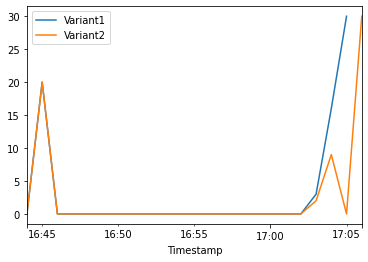

In [18]:
time.sleep(60) #let metrics catch up
plot_endpoint_metrics()

**Note:** If you observe failure, such as a blank graph, re-run the previous step.

### Evaluate performance of variant 2

In [19]:
# Calculate accuracy

labels2 = test_data_with_label[0].to_numpy()
preds2 = np.array(predictions2)
preds2 = preds2.astype(np.int)

accuracy2 = np.count_nonzero(preds2 == labels2) / len(labels2)
print(f"Accuracy_variant2: {accuracy2}")

Accuracy_variant2: 0.9333333333333333


## Step 3: Dialing up your chosen variant in production

Now that you have determined Variant2 to be better as compared to Variant1, you will shift more traffic to it. 

You can continue to use TargetVariant to continue invoking a chosen variant. A simpler approach is to update the weights assigned to each variant using UpdateEndpointWeightsAndCapacities. This changes the traffic distribution to your production variants without requiring updates to your endpoint. 

Recall your variant weights are as follows:

In [20]:
{
    variant["VariantName"]: variant["CurrentWeight"]
    for variant in sm.describe_endpoint(EndpointName=endpoint_name)["ProductionVariants"]
}

{'Variant1': 1.0, 'Variant2': 1.0}

You will first write a method to easily invoke your endpoint (a copy of what you had been previously doing).

In [21]:
def invoke_endpoint_for_two_minutes():
    with open('data/data-test.csv', 'r') as f:
        for row in f:
            print(".", end="", flush=True)
            payload = row.rstrip('\n')
            response = sm_runtime.invoke_endpoint(EndpointName=endpoint_name,
                                                  ContentType='text/csv', 
                                                  Body=payload)
            response['Body'].read()
            time.sleep(1)

You invoke your endpoint for a bit, to show the even split in invocations.

**Note** This step will take 3-5 minutes to complete.

..............................

,Variant1,Variant2
Timestamp,,
2021-05-24 17:07:00+00:00,10.0,4.0
2021-05-24 17:08:00+00:00,6.0,10.0
2021-05-24 17:09:00+00:00,0.0,0.0


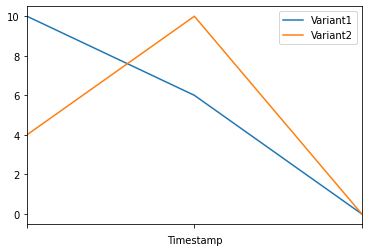

In [22]:
invocation_start_time = datetime.now()
invoke_endpoint_for_two_minutes()
time.sleep(120) # give metrics time to catch up
plot_endpoint_metrics(invocation_start_time)

**Note:** If you observe failure, such as a blank graph, re-run the previous step.

Now let's shift 75% of the traffic to Variant2 by assigning new weights to each variant using UpdateEndpointWeightsAndCapacities. Amazon SageMaker will now send 75% of the inference requests to Variant2 and the remaining 25% of requests to Variant1.

In [23]:
sm.update_endpoint_weights_and_capacities(
    EndpointName=endpoint_name,
    DesiredWeightsAndCapacities=[
        {
            "DesiredWeight": 25,
            "VariantName": 'Variant1'
        },
        {
            "DesiredWeight": 75,
            "VariantName": 'Variant2'
        }
    ]
)

{'EndpointArn': 'arn:aws:sagemaker:us-west-2:581031220190:endpoint/endpoint-63be92ef-5728-43e0-80ed-d6e665750f8b',
 'ResponseMetadata': {'RequestId': 'e2963c76-c161-41e7-a93b-975c7afd51d4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'e2963c76-c161-41e7-a93b-975c7afd51d4',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '113',
   'date': 'Mon, 24 May 2021 17:10:17 GMT'},
  'RetryAttempts': 0}}

In [24]:
print("Waiting for update to complete")
while True:
    status = sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
    if status in ["InService", "Failed"]:
        print("Done")
        break
    print(".", end="", flush=True)
    time.sleep(1)

{
    variant["VariantName"]: variant["CurrentWeight"]
    for variant in sm.describe_endpoint(EndpointName=endpoint_name)["ProductionVariants"]
}

Waiting for update to complete
............................................................Done


{'Variant1': 25.0, 'Variant2': 75.0}

..............................

,Variant1,Variant2
Timestamp,,
2021-05-24 17:07:00+00:00,10.0,4.0
2021-05-24 17:08:00+00:00,6.0,10.0
2021-05-24 17:09:00+00:00,0.0,0.0
2021-05-24 17:10:00+00:00,0.0,0.0
2021-05-24 17:11:00+00:00,4.0,26.0


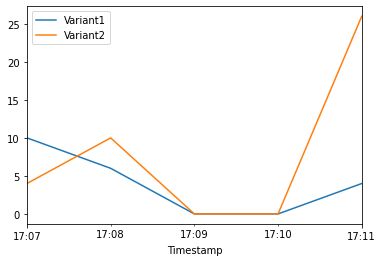

In [25]:
invoke_endpoint_for_two_minutes()
time.sleep(120) # give metrics time to catch up
plot_endpoint_metrics(invocation_start_time)

**Note:** If you observe failure, such as a blank graph, re-run the previous step.

You can continue to monitor your metrics and when you're satisfied with a variant's performance, you can route 100% of the traffic over the variant. You used UpdateEndpointWeightsAndCapacities to update the traffic assignments for the variants. The weight for Variant1 is set to 0 and the weight for Variant2 is set to 1. Therefore, SageMaker will send 100% of all inference requests to Variant2.

### Challenge 

Now you know how to tune your traffic. Can you complete the following code to send 100% traffic to Variant2?

In [26]:
sm.update_endpoint_weights_and_capacities(
    EndpointName=endpoint_name,
    DesiredWeightsAndCapacities=[
        {
            "DesiredWeight": 0,
            "VariantName": 'Variant1'
        },
        {
            "DesiredWeight": 1,
            "VariantName": 'Variant2'
        }
    ]
)
print("Waiting for update to complete")
while True:
    status = sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
    if status in ["InService", "Failed"]:
        print("Done")
        break
    print(".", end="", flush=True)
    time.sleep(1)

{
    variant["VariantName"]: variant["CurrentWeight"]
    for variant in sm.describe_endpoint(EndpointName=endpoint_name)["ProductionVariants"]
}

Waiting for update to complete
............................................................Done


{'Variant1': 0.0, 'Variant2': 1.0}

..............................

,Variant1,Variant2
Timestamp,,
2021-05-24 17:07:00+00:00,10.0,4.0
2021-05-24 17:08:00+00:00,6.0,10.0
2021-05-24 17:09:00+00:00,0.0,0.0
2021-05-24 17:10:00+00:00,0.0,0.0
2021-05-24 17:11:00+00:00,4.0,26.0
2021-05-24 17:13:00+00:00,0.0,0.0
2021-05-24 17:14:00+00:00,0.0,1.0
2021-05-24 17:15:00+00:00,0.0,29.0
2021-05-24 17:16:00+00:00,0.0,NaN


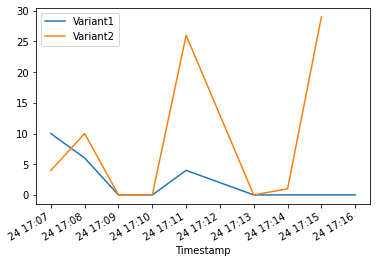

In [27]:
invoke_endpoint_for_two_minutes()
time.sleep(120) # give metrics time to catch up
plot_endpoint_metrics(invocation_start_time)

**Note:** If you observe failure, such as a blank graph, re-run the previous step.

The Amazon CloudWatch metrics for the total invocations for each variant indicates that all inference requests are being processed by Variant2 and there are no inference requests processed by Variant1.

You can now safely update your endpoint and delete Variant1 from it. You can also continue testing new models in production by adding new variants to your endpoint and following steps 2 - 4.

"To review the solution notebook, see the **[Lab 2 A/B testing solution](../solutions/Lab2-AB_Testing-Solution.ipynb)**.

## Delete the endpoint

If you do not plan to use this endpoint further, you should delete it to avoid incurring additional charges.

In [ ]:
sm_session.delete_endpoint(endpoint_name)